In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import json
import numpy as np
import pandas as pd
from collections import Counter
# Plot Images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
plt.style.use('ggplot')
import matplotlib
# Set GPU usage
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# Plotly 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [3]:
cd ..

/home/albert/aip-eval


In [4]:
from studio.evaluation.keras import metrics, utils, visualizer
from studio.evaluation.keras.evaluators import CNNEvaluator

Using TensorFlow backend.


In [5]:
test_image_path = '/data/datasets/133_way_150_min_april_2019/app_incoming_sept_2019/'
ensemble_models_dir = '/data/models/133_way_april_2019/3_ensemble/'
app_incoming_manifest_path = '/data/datasets/133_way_150_min_april_2019/app_incoming_sept_2019/manifest.json'
reviews_csv_path = '233.csv'
visual_dictionary_json_path = '/home/albert/github_repos/aip-visual/models_info/133_way_april_2019/ontology_snapshots/133_way_min_150_images_april_2019_model_map_diagnosis_nodes.json'
visual_dictionary_csv_path = '/home/albert/github_repos/aip-visual/models_info/133_way_april_2019/ontology_snapshots/133_way_min_150_images_april_2019_model_map_diagnosis_nodes.csv'

### Data Preparation

In [6]:
app_incoming_manifest_df = pd.read_json(app_incoming_manifest_path)

In [7]:
# Ids --> Filename Dictionary
id_filename_dict = {str(image_id):app_incoming_manifest_df['filename'][i] for i, image_id in enumerate(app_incoming_manifest_df['id'])}
# Filenames --> GT label Dictionary
filename_label_gt = {app_incoming_manifest_df['filename'][i]:class_dict['class_index'] for i, class_dict in enumerate(app_incoming_manifest_df['dictionary'])}

In [8]:
with open(visual_dictionary_json_path, 'r') as f:
    visual_dictionary = json.load(f)

In [9]:
visual_dict_df = pd.read_csv(visual_dictionary_csv_path)

In [10]:
visual_dict_df.head()

,class_index,diagnosis_name,diagnosis_id,condition_name,condition_id,n_samples
0,0,acne scarring,AIP:0100060,"['acne scarring', 'acne-vulgaris-scarring']","['AIP:0100060', 'AIP:002471d']",206
1,1,acne variant,AIP:0003528,"['acne fulminans', 'acne variant', 'acne necro...","['AIP:0002478', 'AIP:0003528', 'AIP:0...",312
2,2,acne vulgaris,AIP:0002471,"['open comedone acne', 'acne vulgaris', 'acne-...","['AIP:0002474', 'AIP:0002471', 'AIP:0...",2845
3,3,acneiform eruption,AIP:0002475,"['chloracne', 'iododerma', 'steroid acne', 'po...","['AIP:0001376', 'AIP:0001382', 'AIP:0...",195
4,4,actinic keratosis,AIP:0000396,"['pigmented AK', 'lichenoid AK', 'infected act...","['AIP:0000398', 'AIP:0000399', 'AIP:0...",6058


In [11]:
diagnosis_class_index = {diagnosis_id:visual_dict_df['class_index'][i] for i, diagnosis_id in enumerate(visual_dict_df['diagnosis_id'])}

In [12]:
diagnosis_condition_ids = {}
condition_to_diagnosis = {}
strings_to_remove = ['[',']', '\'', ' ']
for i, item in enumerate(visual_dict_df['condition_id']):
    for s in strings_to_remove:
        item = item.replace(s, '')
    conditions = item.split(',')
    diagnosis_condition_ids[visual_dict_df['diagnosis_id'][i]] = list(set(conditions))
    for cond in conditions:
        condition_to_diagnosis[cond] = visual_dict_df['diagnosis_id'][i]

In [13]:
reviews_df = pd.read_csv('233.csv')

In [14]:
reviews_df.head()

,Reviewer,Email,Image ID,App ID,Image filename,Choice,Choice tag,Timestamp
0,Yahia Ahmad,nephroncreat@gmail.com,1017568,e24169fc-aa5d-45ee-a1a5-a5fe9476bcdb-153313917...,e24169fc_aa5d_45ee_a1a5_a5fe9476bcdb_153313917...,plaque-psoriasis-bright-red,AIP:003512c,2019-08-19 20:41:48 UTC
1,Rasha Shawkat,rshawkat77@gmail.com,1017568,e24169fc-aa5d-45ee-a1a5-a5fe9476bcdb-153313917...,e24169fc_aa5d_45ee_a1a5_a5fe9476bcdb_153313917...,contact dermatitis,AIP:0001341,2019-08-19 22:00:30 UTC
2,Rasha Shawkat,rshawkat77@gmail.com,1017794,7716768f-4f7f-4adb-a45a-5143c5191be0-img_20180...,7716768f_4f7f_4adb_a45a_5143c5191be0_img_20180...,tinea corporis,AIP:0002259,2019-08-19 22:01:08 UTC
3,Rasha Shawkat,rshawkat77@gmail.com,1018021,25ee09e8-fb73-4774-930d-f809cdaf2110-153315608...,25ee09e8_fb73_4774_930d_f809cdaf2110_153315608...,atopic-eczema,AIP:000122f,2019-08-19 22:05:40 UTC
4,Rasha Shawkat,rshawkat77@gmail.com,1018046,c2eba2a5-a53d-4a56-a3ca-f2d2bc8c0cf2-img_0813.jpg,c2eba2a5_a53d_4a56_a3ca_f2d2bc8c0cf2_img_0813_...,folliculitis,AIP:0002523,2019-08-19 22:08:48 UTC


In [15]:
diagnosis_id_review = {str(case_id):[] for case_id in reviews_df['Image ID'].unique()}
diagnosis_id_review_cnn_index = {str(case_id):[] for case_id in reviews_df['Image ID'].unique()}
for i, choice in enumerate(reviews_df['Choice tag']):
    if choice in condition_to_diagnosis.keys():
        diagnosis_id = condition_to_diagnosis[choice]
        diagnosis_id_review[str(reviews_df['Image ID'][i])].append(diagnosis_id)
        diagnosis_id_review_cnn_index[str(reviews_df['Image ID'][i])].append(diagnosis_class_index[diagnosis_id])

In [16]:
diagnosis_id_review_final = {key:values for key, values in diagnosis_id_review_cnn_index.items() if len(values) > 0}

In [17]:
# Dictionary 'diagnosis_id':[CNN_Indices_Reviews] 
diagnosis_id_review_final

{'1017568': [15, 20, 87, 76, 120],
 '1017794': [120, 120, 15, 43, 120],
 '1018021': [6],
 '1018046': [38, 38, 38],
 '1018048': [3],
 '1018050': [3],
 '1018508': [128, 6, 128, 109, 129],
 '1019042': [128, 20],
 '1020455': [38, 1, 64, 38, 1],
 '1020458': [62, 62, 62],
 '1020461': [38, 109, 120],
 '1020464': [38, 109, 120],
 '1020468': [38, 38, 109, 120],
 '1022123': [6, 6, 6],
 '1022125': [43],
 '1022128': [20],
 '1022131': [21, 131, 6, 21],
 '1022134': [21, 131, 6, 21],
 '1022140': [20, 15, 15, 15],
 '1022143': [38, 20],
 '1022426': [20, 121],
 '1022429': [121],
 '1022435': [38, 38, 38],
 '1022444': [20],
 '1022447': [120, 128, 70, 120, 123],
 '1022450': [18, 105, 32, 105, 110],
 '1022453': [6],
 '1022456': [54, 62, 76],
 '1022462': [104, 29, 24, 130],
 '1022464': [104, 67, 130, 29],
 '1022467': [15, 15, 20, 15],
 '1024976': [21, 21],
 '1024992': [76],
 '1031301': [74, 74, 74],
 '1036720': [8, 8, 8],
 '1047523': [20, 109, 20, 20],
 '1057036': [6, 6, 54, 6],
 '1069829': [6, 62, 62, 62],


In [18]:
id_labels_votes_ranked = {}
id_labels_votes_unranked = {}
for key, values in diagnosis_id_review_final.items():
    values_count = Counter(values).most_common()
    id_labels_votes_ranked[key] = values_count
    id_labels_votes_unranked[key] = list(set([value[0] for value in values_count]))

In [19]:
# Dictionary with 'diagnosis_id':[(CNN_Index, Votes_Count)] 
id_labels_votes_ranked

{'1017568': [(15, 1), (20, 1), (87, 1), (76, 1), (120, 1)],
 '1017794': [(120, 3), (15, 1), (43, 1)],
 '1018021': [(6, 1)],
 '1018046': [(38, 3)],
 '1018048': [(3, 1)],
 '1018050': [(3, 1)],
 '1018508': [(128, 2), (6, 1), (109, 1), (129, 1)],
 '1019042': [(128, 1), (20, 1)],
 '1020455': [(38, 2), (1, 2), (64, 1)],
 '1020458': [(62, 3)],
 '1020461': [(38, 1), (109, 1), (120, 1)],
 '1020464': [(38, 1), (109, 1), (120, 1)],
 '1020468': [(38, 2), (109, 1), (120, 1)],
 '1022123': [(6, 3)],
 '1022125': [(43, 1)],
 '1022128': [(20, 1)],
 '1022131': [(21, 2), (131, 1), (6, 1)],
 '1022134': [(21, 2), (131, 1), (6, 1)],
 '1022140': [(15, 3), (20, 1)],
 '1022143': [(38, 1), (20, 1)],
 '1022426': [(20, 1), (121, 1)],
 '1022429': [(121, 1)],
 '1022435': [(38, 3)],
 '1022444': [(20, 1)],
 '1022447': [(120, 2), (128, 1), (70, 1), (123, 1)],
 '1022450': [(105, 2), (18, 1), (32, 1), (110, 1)],
 '1022453': [(6, 1)],
 '1022456': [(54, 1), (62, 1), (76, 1)],
 '1022462': [(104, 1), (29, 1), (24, 1), (130, 

In [20]:
# Dictionary with 'diagnosis_id':[(CNN_Indices)] -- No duplicates
id_labels_votes_unranked

{'1017568': [76, 15, 20, 87, 120],
 '1017794': [120, 43, 15],
 '1018021': [6],
 '1018046': [38],
 '1018048': [3],
 '1018050': [3],
 '1018508': [128, 129, 109, 6],
 '1019042': [128, 20],
 '1020455': [64, 1, 38],
 '1020458': [62],
 '1020461': [120, 109, 38],
 '1020464': [120, 109, 38],
 '1020468': [120, 109, 38],
 '1022123': [6],
 '1022125': [43],
 '1022128': [20],
 '1022131': [131, 21, 6],
 '1022134': [131, 21, 6],
 '1022140': [20, 15],
 '1022143': [20, 38],
 '1022426': [121, 20],
 '1022429': [121],
 '1022435': [38],
 '1022444': [20],
 '1022447': [120, 123, 128, 70],
 '1022450': [32, 105, 18, 110],
 '1022453': [6],
 '1022456': [62, 76, 54],
 '1022462': [104, 24, 130, 29],
 '1022464': [104, 130, 67, 29],
 '1022467': [20, 15],
 '1024976': [21],
 '1024992': [76],
 '1031301': [74],
 '1036720': [8],
 '1047523': [20, 109],
 '1057036': [54, 6],
 '1069829': [62, 6],
 '1069832': [20],
 '1069834': [15],
 '1069837': [62],
 '1069840': [104, 16, 4, 95],
 '1069843': [20, 15],
 '1070996': [7],
 '10712

In [22]:
n_differentials_condition = [len(reviews) for reviews in list(id_labels_votes_ranked.values())]
print('Mean differentials per condition: ', np.mean(n_differentials_condition))
print('Max differentials per condition: ', np.max(n_differentials_condition))
print('Min differentials per condition: ', np.min(n_differentials_condition))
print('Median differentials per condition: ', np.median(n_differentials_condition))

Mean differentials per condition:  1.6368267831149927
Max differentials per condition:  5
Min differentials per condition:  1
Median differentials per condition:  1.0


In [23]:
filenames_labels_votes_ranked = {id_filename_dict[image_id]: label for image_id, label in id_labels_votes_ranked.items() if image_id in id_filename_dict.keys()}
filenames_labels_unranked = {id_filename_dict[image_id]: label for image_id, label in id_labels_votes_unranked.items() if image_id in id_filename_dict.keys()}

In [24]:
filenames = list(filenames_labels_unranked.keys())
labels_gt = [filename_label_gt[filename] for filename in filenames]
labels_unranked = list(filenames_labels_unranked.values())
labels_votes_ranked = list(filenames_labels_votes_ranked.values())

In [25]:
image_paths = [os.path.join(test_image_path, filename) for filename in filenames]

### Evaluation

In [26]:
concepts_list = [{'id': item['diagnosis_name'], 'label': item['diagnosis_name']} for item in visual_dictionary]

In [27]:
cnn_evaluator = CNNEvaluator(
        concept_dictionary_path=None,
        custom_objects=None,
        concepts=concepts_list,
        ensemble_models_dir=ensemble_models_dir,
        batch_size=32,
        verbose=0)

Loading model  model_max_acc_1gpu.h5


/home/albert/aip-eval/.venv/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning:

No training configuration found in save file: the model was *not* compiled. Compile it manually.



Loading model  model_max_acc_1gpu.h5
Loading model  model_max_acc_1_gpu_python3_6.h5
Models loaded:  3


In [28]:
visual_probabilities = cnn_evaluator.predict(image_paths)

Making predictions from model  0
23/24 [===========================>..] - ETA: 6s 
Processing remainder: 2
Making predictions from model  1
23/24 [===========================>..] - ETA: 6s 
Processing remainder: 2
Making predictions from model  2
23/24 [===========================>..] - ETA: 6s 
Processing remainder: 2


In [29]:
results = cnn_evaluator.get_metrics(visual_probabilities, np.array(labels_gt), top_k=10)

In [30]:
cnn_evaluator.show_results('average')

,id,accuracy_top_1,accuracy_top_2,accuracy_top_3,accuracy_top_4,accuracy_top_5,accuracy_top_6,accuracy_top_7,accuracy_top_8,accuracy_top_9,accuracy_top_10,weighted_precision,sensitivity,precision,weighted_f1_score,number_of_samples,number_of_classes
0,None,0.557,0.682,0.755,0.805,0.845,0.873,0.887,0.903,0.916,0.929,0.724,0.473,0.353,0.596,770,133


In [31]:
cnn_evaluator.show_results('individual').sort_values('n_samples', ascending=False)

,id,class,sensitivity_top_1,sensitivity_top_2,sensitivity_top_3,sensitivity_top_4,sensitivity_top_5,sensitivity_top_6,sensitivity_top_7,sensitivity_top_8,sensitivity_top_9,sensitivity_top_10,precision,f1_score,TP,FP,FN,n_samples,% samples
15,None,chronic plaque psoriasis,0.712,0.801,0.858,0.893,0.923,0.950,0.953,0.964,0.976,0.979,0.899,0.795,240,27,97,337,43.77
18,None,common acquired melanocytic nevus,0.471,0.676,0.765,0.853,0.853,0.882,0.882,0.882,0.897,0.926,0.800,0.593,32,8,36,68,8.83
78,None,palmoplantar-psoriasis,0.299,0.537,0.746,0.881,0.910,0.940,0.970,0.970,0.970,0.970,0.952,0.455,20,1,47,67,8.70
20,None,contact dermatitis,0.077,0.154,0.246,0.354,0.523,0.631,0.692,0.738,0.754,0.785,0.357,0.127,5,9,60,65,8.44
6,None,atopic dermatitis,0.353,0.353,0.412,0.412,0.529,0.529,0.588,0.588,0.647,0.765,0.750,0.480,6,2,11,17,2.21
7,None,atypical melanocytic proliferation and cannot ...,0.667,0.867,0.933,0.933,0.933,0.933,0.933,0.933,0.933,1.000,0.455,0.541,10,12,5,15,1.95
104,None,seborrheic dermatitis,0.667,0.917,0.917,0.917,0.917,0.917,0.917,0.917,0.917,0.917,0.500,0.571,8,8,4,12,1.56
89,None,pityriasis versicolor,0.727,0.909,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.800,0.762,8,2,3,11,1.43
2,None,acne vulgaris,0.900,0.900,0.900,0.900,0.900,1.000,1.000,1.000,1.000,1.000,0.529,0.667,9,8,1,10,1.30
95,None,psoriasis of the scalp,0.444,0.667,0.778,0.778,0.778,0.778,0.778,0.778,0.778,0.778,0.667,0.533,4,2,5,9,1.17


In [32]:
visual_predictions = np.argsort(visual_probabilities, axis=1)[:, ::-1]

### Evaluation of differential labels

In [34]:
# Unranked Measure
mean_recall = metrics.mean_recall_at_k(visual_predictions, labels_unranked, k=5)

In [35]:
print('The mean recall for differentials is ', mean_recall)

The mean recall for differentials is  0.7779220779220779


In [36]:
# Functions to create hypothesis and references to apply NDCG

def create_ranked_reference_from_votes(labels_differentials, top_k):
    """
    Create reference for ranked differentials
    """
    references = []
    for labels in labels_differentials:
        reference = []
        for i, label in enumerate(labels):
            if i <= top_k:
                reference.append(label[1])
            else:
                break
        if len(labels) < top_k:
            reference += [0] * (top_k - len(labels))
        references.append(reference)
    return references

def create_ranked_hypothesis_from_votes(visual_predictions, labels_differentials, top_k):
    """
    Create reference for ranked differentials
    Sorted visual predictions
    """
    hyphothesis_list = []
    for k, predictions in enumerate(visual_predictions[:, 0:top_k]):
        hyphothesis = []
        prediction_scores = {label[0]: label[1] for label in labels_differentials[k]}
        for prediction in predictions:
            if prediction in prediction_scores.keys():
                hyphothesis.append(prediction_scores[prediction])
            else:
                hyphothesis.append(0)
        hyphothesis_list.append(hyphothesis)
    return hyphothesis_list

In [75]:
references = create_ranked_reference_from_votes(labels_votes_ranked, top_k=10)

In [76]:
hypothesis = create_ranked_hypothesis_from_votes(visual_predictions, labels_votes_ranked, top_k=10)

In [77]:
ndcgs = []
for i in range(len(references)):
    ndcgs.append(metrics.compute_ndcg(references[i], hypothesis[i]))

In [78]:
print('Mean Normalized Discount gain: ', round(np.mean(ndcgs), 4))

Mean Normalized Discount gain:  0.7297


In [42]:
sorted_ndcgs = np.argsort(ndcgs)

In [52]:
concepts_list_array = np.array(concepts_list)

### Cases with bad NDCG

0.0
['basal cell carcinoma', 'tinea corporis', 'tinea incognito', 'tinea cruris', 'common acquired melanocytic nevus']
Label chronic plaque psoriasis | Votes 3 


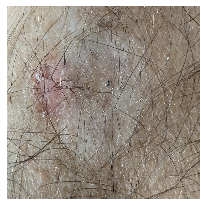

In [57]:
index = sorted_ndcgs[0]
print(ndcgs[index])
concepts_predicted = concepts_list_array[visual_predictions[index, 0:5]]
print([concept['label'] for concept in concepts_predicted])
for label in labels_votes_ranked[index]: 
    print('Label %s | Votes %i ' % (concepts_list_array[label[0]]['label'], label[1]))
cnn_evaluator.plot_images([image_paths[index]])


0.0
['tinea corporis', 'tinea incognito', 'molluscum contagiosum', 'tinea cruris', 'atypical melanocytic proliferation and cannot rule out melanoma']
Label chronic plaque psoriasis | Votes 3 
Label keloid scarring | Votes 1 


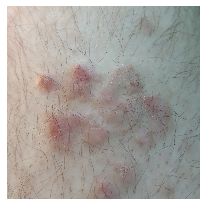

In [58]:
index = sorted_ndcgs[1]
print(ndcgs[index])
concepts_predicted = concepts_list_array[visual_predictions[index, 0:5]]
print([concept['label'] for concept in concepts_predicted])
for label in labels_votes_ranked[index]: 
    print('Label %s | Votes %i ' % (concepts_list_array[label[0]]['label'], label[1]))
cnn_evaluator.plot_images([image_paths[index]])

0.0
['striae', 'surgical scar', 'vitiligo', 'common acquired melanocytic nevus', 'tinea corporis']
Label telangiectasia | Votes 3 


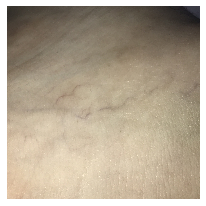

In [59]:
index = sorted_ndcgs[2]
print(ndcgs[index])
concepts_predicted = concepts_list_array[visual_predictions[index, 0:5]]
print([concept['label'] for concept in concepts_predicted])
for label in labels_votes_ranked[index]: 
    print('Label %s | Votes %i ' % (concepts_list_array[label[0]]['label'], label[1]))
cnn_evaluator.plot_images([image_paths[index]])

0.0
['common acquired melanocytic nevus', 'tinea corporis', 'non-cicatricial alopecia', 'striae', 'vitiligo']
Label telangiectasia | Votes 3 


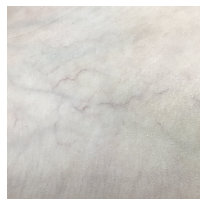

In [60]:
index = sorted_ndcgs[3]
print(ndcgs[index])
concepts_predicted = concepts_list_array[visual_predictions[index, 0:5]]
print([concept['label'] for concept in concepts_predicted])
for label in labels_votes_ranked[index]: 
    print('Label %s | Votes %i ' % (concepts_list_array[label[0]]['label'], label[1]))
cnn_evaluator.plot_images([image_paths[index]])

### Cases with good NDCG

1.0
['chronic plaque psoriasis', 'porokeratosis', 'lichen planus', 'granuloma annulare', 'guttate psoriasis']
Label chronic plaque psoriasis | Votes 3 


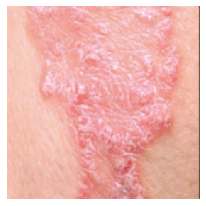

In [61]:
index = sorted_ndcgs[-1]
print(ndcgs[index])
concepts_predicted = concepts_list_array[visual_predictions[index, 0:5]]
print([concept['label'] for concept in concepts_predicted])
for label in labels_votes_ranked[index]: 
    print('Label %s | Votes %i ' % (concepts_list_array[label[0]]['label'], label[1]))
cnn_evaluator.plot_images([image_paths[index]])

1.0
['chronic plaque psoriasis', 'lichen simplex chronicus', 'vitiligo', 'erythrodermic psoriasis', 'guttate psoriasis']
Label chronic plaque psoriasis | Votes 3 


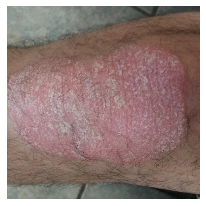

In [62]:
index = sorted_ndcgs[-2]
print(ndcgs[index])
concepts_predicted = concepts_list_array[visual_predictions[index, 0:5]]
print([concept['label'] for concept in concepts_predicted])
for label in labels_votes_ranked[index]: 
    print('Label %s | Votes %i ' % (concepts_list_array[label[0]]['label'], label[1]))
cnn_evaluator.plot_images([image_paths[index]])

1.0
['atypical melanocytic proliferation and cannot rule out melanoma', 'common acquired melanocytic nevus', 'basal cell carcinoma', 'seborrheic keratosis', 'urticaria']
Label atypical melanocytic proliferation and cannot rule out melanoma | Votes 3 
Label common acquired melanocytic nevus | Votes 1 


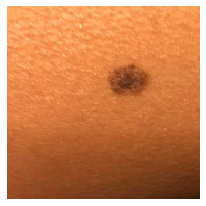

In [63]:
index = sorted_ndcgs[-3]
print(ndcgs[index])
concepts_predicted = concepts_list_array[visual_predictions[index, 0:5]]
print([concept['label'] for concept in concepts_predicted])
for label in labels_votes_ranked[index]: 
    print('Label %s | Votes %i ' % (concepts_list_array[label[0]]['label'], label[1]))
cnn_evaluator.plot_images([image_paths[index]])

0.6309297535714574
['tinea capitis', 'seborrheic dermatitis', 'psoriasis of the scalp', 'pediculosis', 'chronic plaque psoriasis']
Label seborrheic dermatitis | Votes 3 


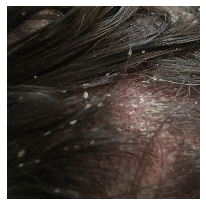

In [74]:
index = sorted_ndcgs[-500]
print(ndcgs[index])
concepts_predicted = concepts_list_array[visual_predictions[index, 0:5]]
print([concept['label'] for concept in concepts_predicted])
for label in labels_votes_ranked[index]: 
    print('Label %s | Votes %i ' % (concepts_list_array[label[0]]['label'], label[1]))
cnn_evaluator.plot_images([image_paths[index]])